In [39]:
import sys
import math

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [40]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [41]:
 palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3"]

#### Set up scVI environment

In [42]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

In [43]:
import pandas as pd 
import numpy as np

# SOMATIC

### Read in dataset

In [44]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')

## Annotate cells

In [45]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
# Add old cluster subname
meta = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/old/FCA-gonads_scVI_supporting_1stEarly.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

cell_annot = meta['celltype'].to_dict()
adata.obs['celltype_v2'] = adata.obs_names.map(cell_annot).astype('category')
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')

In [47]:
adata.obs['lineage'].values.describe()

,counts,freqs
categories,,
CoelEpi,23360,0.058906
Doublet,6131,0.015460
Endothelial,14483,0.036521
Epithelial,19201,0.048418
Erythroid,3485,0.008788
FetalLeydig,2772,0.006990
GermCells,14516,0.036604
Immune,5581,0.014073
Mesenchymal_GATA2,94455,0.238183


In [48]:
adata = adata[[ not pd.isna(i) for i in adata.obs.lineage ]]
adata = adata[[i not in ['lowQC'] for i in adata.obs.lineage]]
adata = adata[[i in ['Supporting', 'Sertoli', 'CoelEpi', 'Mesenchymal_LHX9', 'FetalLeydig'] for i in adata.obs.lineage]]
adata = adata[[float(i) < 8.6 for i in adata.obs.PCW]]
adata.X.shape

(17463, 28820)

In [49]:
adata.obs['lineage'].values.describe()

,counts,freqs
categories,,
CoelEpi,9340,0.534845
Mesenchymal_LHX9,2802,0.160454
Sertoli,10,0.000573
Supporting,5311,0.304129


In [50]:
adata.obs['celltype_v2'].values.describe()

,counts,freqs
categories,,
CoelEpi_GATA2,1877,0.107484
CoelEpi_LHX9,475,0.027200
CoelEpi_LHX9_cycling,2353,0.134742
Doublet,66,0.003779
Gi,910,0.052110
Sertoli,86,0.004925
lowQC,149,0.008532
preGC_I,360,0.020615
sKITLG,1752,0.100326


In [51]:
sc.pp.filter_genes(adata, min_counts=5)

Trying to set attribute `.var` of view, copying.
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/views.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  container[idx] = value


### OPTIONAL - Remove cc genes

In [52]:
# ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 22275


### OPTIONAL - Remove soup genes

In [53]:
# bdata = adata.copy()
# # Normalize total counts per cell
# sc.pp.normalize_per_cell(bdata, counts_per_cell_after=1e4)
# # Logarithmize the data matrix
# sc.pp.log1p(bdata)
# # Extract highly variable genes
# sc.pp.highly_variable_genes(bdata, n_top_genes=4000)
# highly_variable_genes = bdata.var["highly_variable"]
# bdata = bdata[:, highly_variable_genes]
# # Traspose matrix for a GENE-centered analysis
# bdata = bdata.copy().T
# # Scale data to unit variance and zero mean
# sc.pp.scale(bdata, max_value=10)
# # Scatter plot in PCA coordinates
# sc.tl.pca(bdata)
# # Compute a neighborhood graph of observations
# num_pcs = 30
# sc.pp.neighbors(bdata, n_pcs=num_pcs)
# # Embed the neighborhood graph using UMAP
# sc.tl.umap(bdata)
# # Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
# sc.tl.louvain(bdata, resolution=1)
# # Locate ccs cluster
# bdata.obs['soup_genes'] = [i in ['HBA1', 'HBB1'] for i in bdata.obs_names]
# bdata.obs['soup_genes'] = [ str(i) for i in  bdata.obs['soup_genes']]
# sc.pl.umap(bdata, color=['soup_genes', 'louvain'], color_map='OrRd')
# print(bdata.obs.loc[[i in ['HBA1', 'HBB1'] for i in bdata.obs_names],'louvain'])

In [54]:
# soup_cl = bdata.obs.loc['HBA1',['louvain']][0]
# print("Soup genes cluster is "+soup_cl)
# # Add unstructured dict-like annotation for soup_genes
# adata.uns['soup_genes'] = list(bdata.obs[bdata.obs['louvain']==soup_cl].index)

# # remove these genes
# adata = adata[:,[i not in adata.uns['soup_genes'] for i in adata.var_names]]
# print('Total number of genes after soup filter: {:d}'.format(adata.n_vars))

### Identify HVGs

!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI 

--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [55]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3"
)

Trying to set attribute `.uns` of view, copying.


In [56]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

In [57]:
'SRY' in bdata.var_names

True

In [58]:
'LGR5' in bdata.var_names

True

## Normalize - optional

In [59]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## scVI

!!! Here you can specify your covariates you want to correct for

In [60]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='donor',
    categorical_covariate_keys=["sample_source"]
#     continuous_covariate_keys=["percent_mito"]#
)

INFO     Using batches from adata.obs["donor"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 17463 cells, 2000 vars, 8 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [61]:
model = scvi.model.SCVI(bdata, n_latent= 40)

In [62]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 40, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [63]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [14:33<00:00,  2.18s/it, loss=1.07e+03, v_num=1]


In [64]:
latent = model.get_latent_representation()

In [65]:
adata.obsm["X_scVI"] = latent

### Save latent space

In [66]:
pd.DataFrame(adata.obsm["X_scVI"]).to_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_somaticEarly.csv')
pd.DataFrame(adata.obs).to_csv(path_to_gonads+'/FCA-gonads_XscVI_latentMeta_somaticEarly.csv')

### Visualization and Clustering

In [67]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=50)
# sc.tl.umap(adata, min_dist=0.4)
sc.tl.umap(adata, min_dist=0.3, spread = 2)

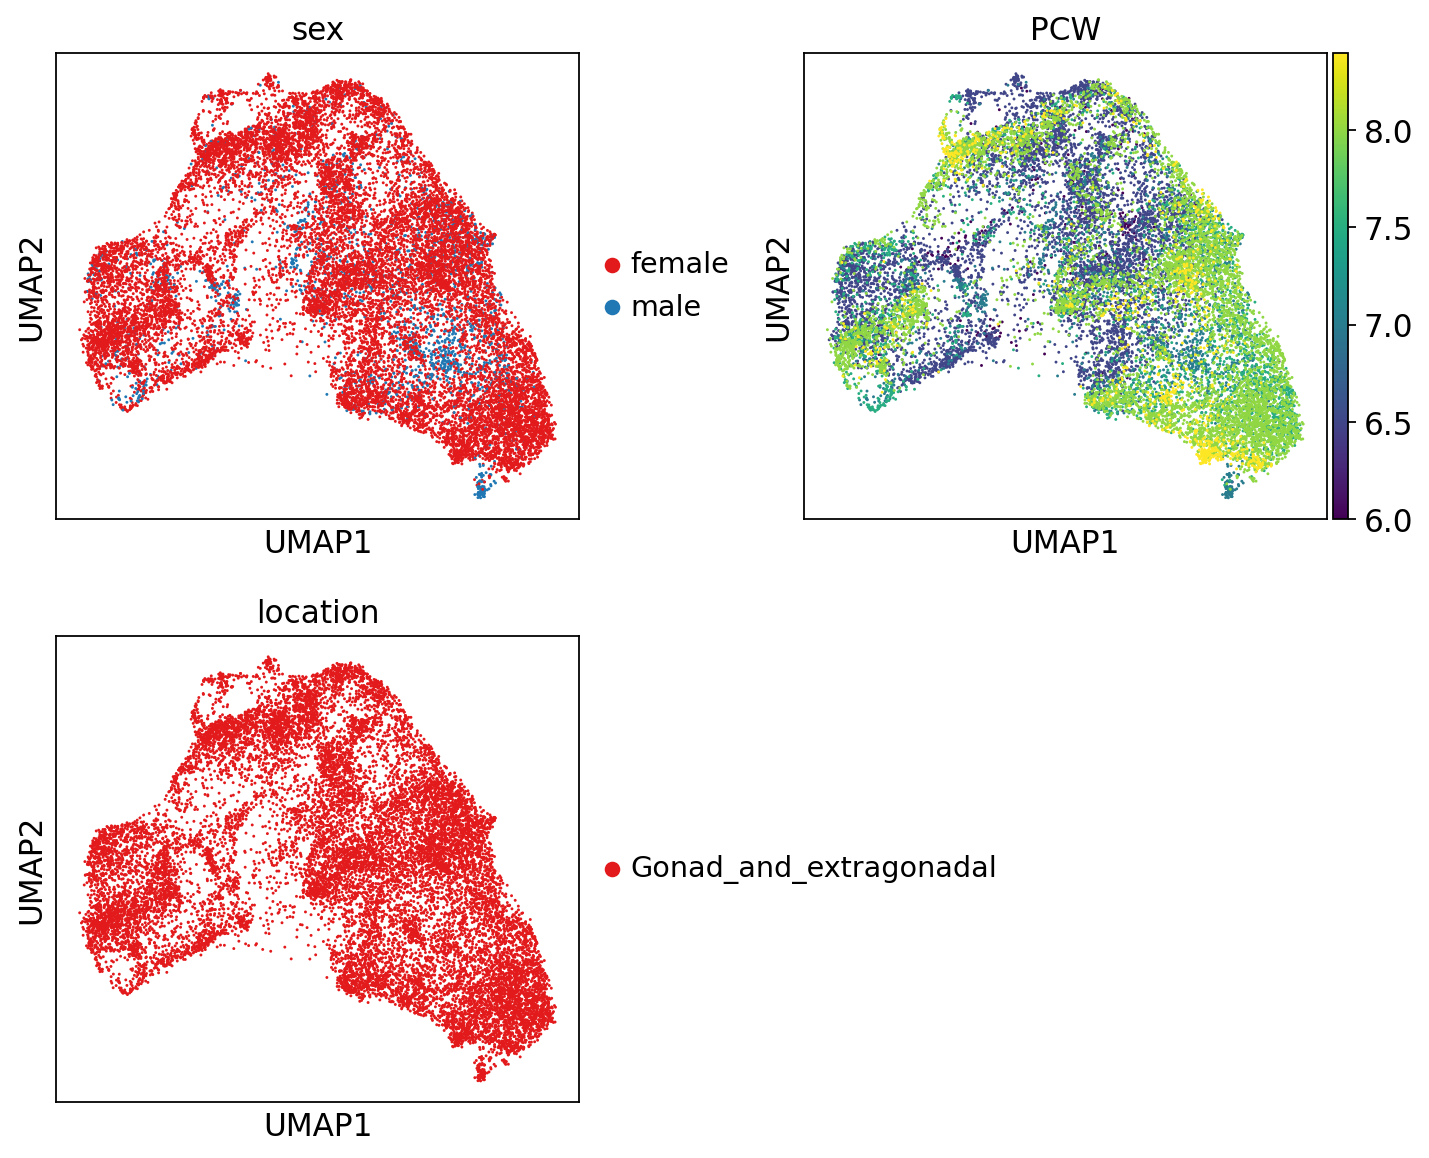

In [69]:
sc.pl.umap(
    adata,
    color=["sex", 'PCW', 'location'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.3
)

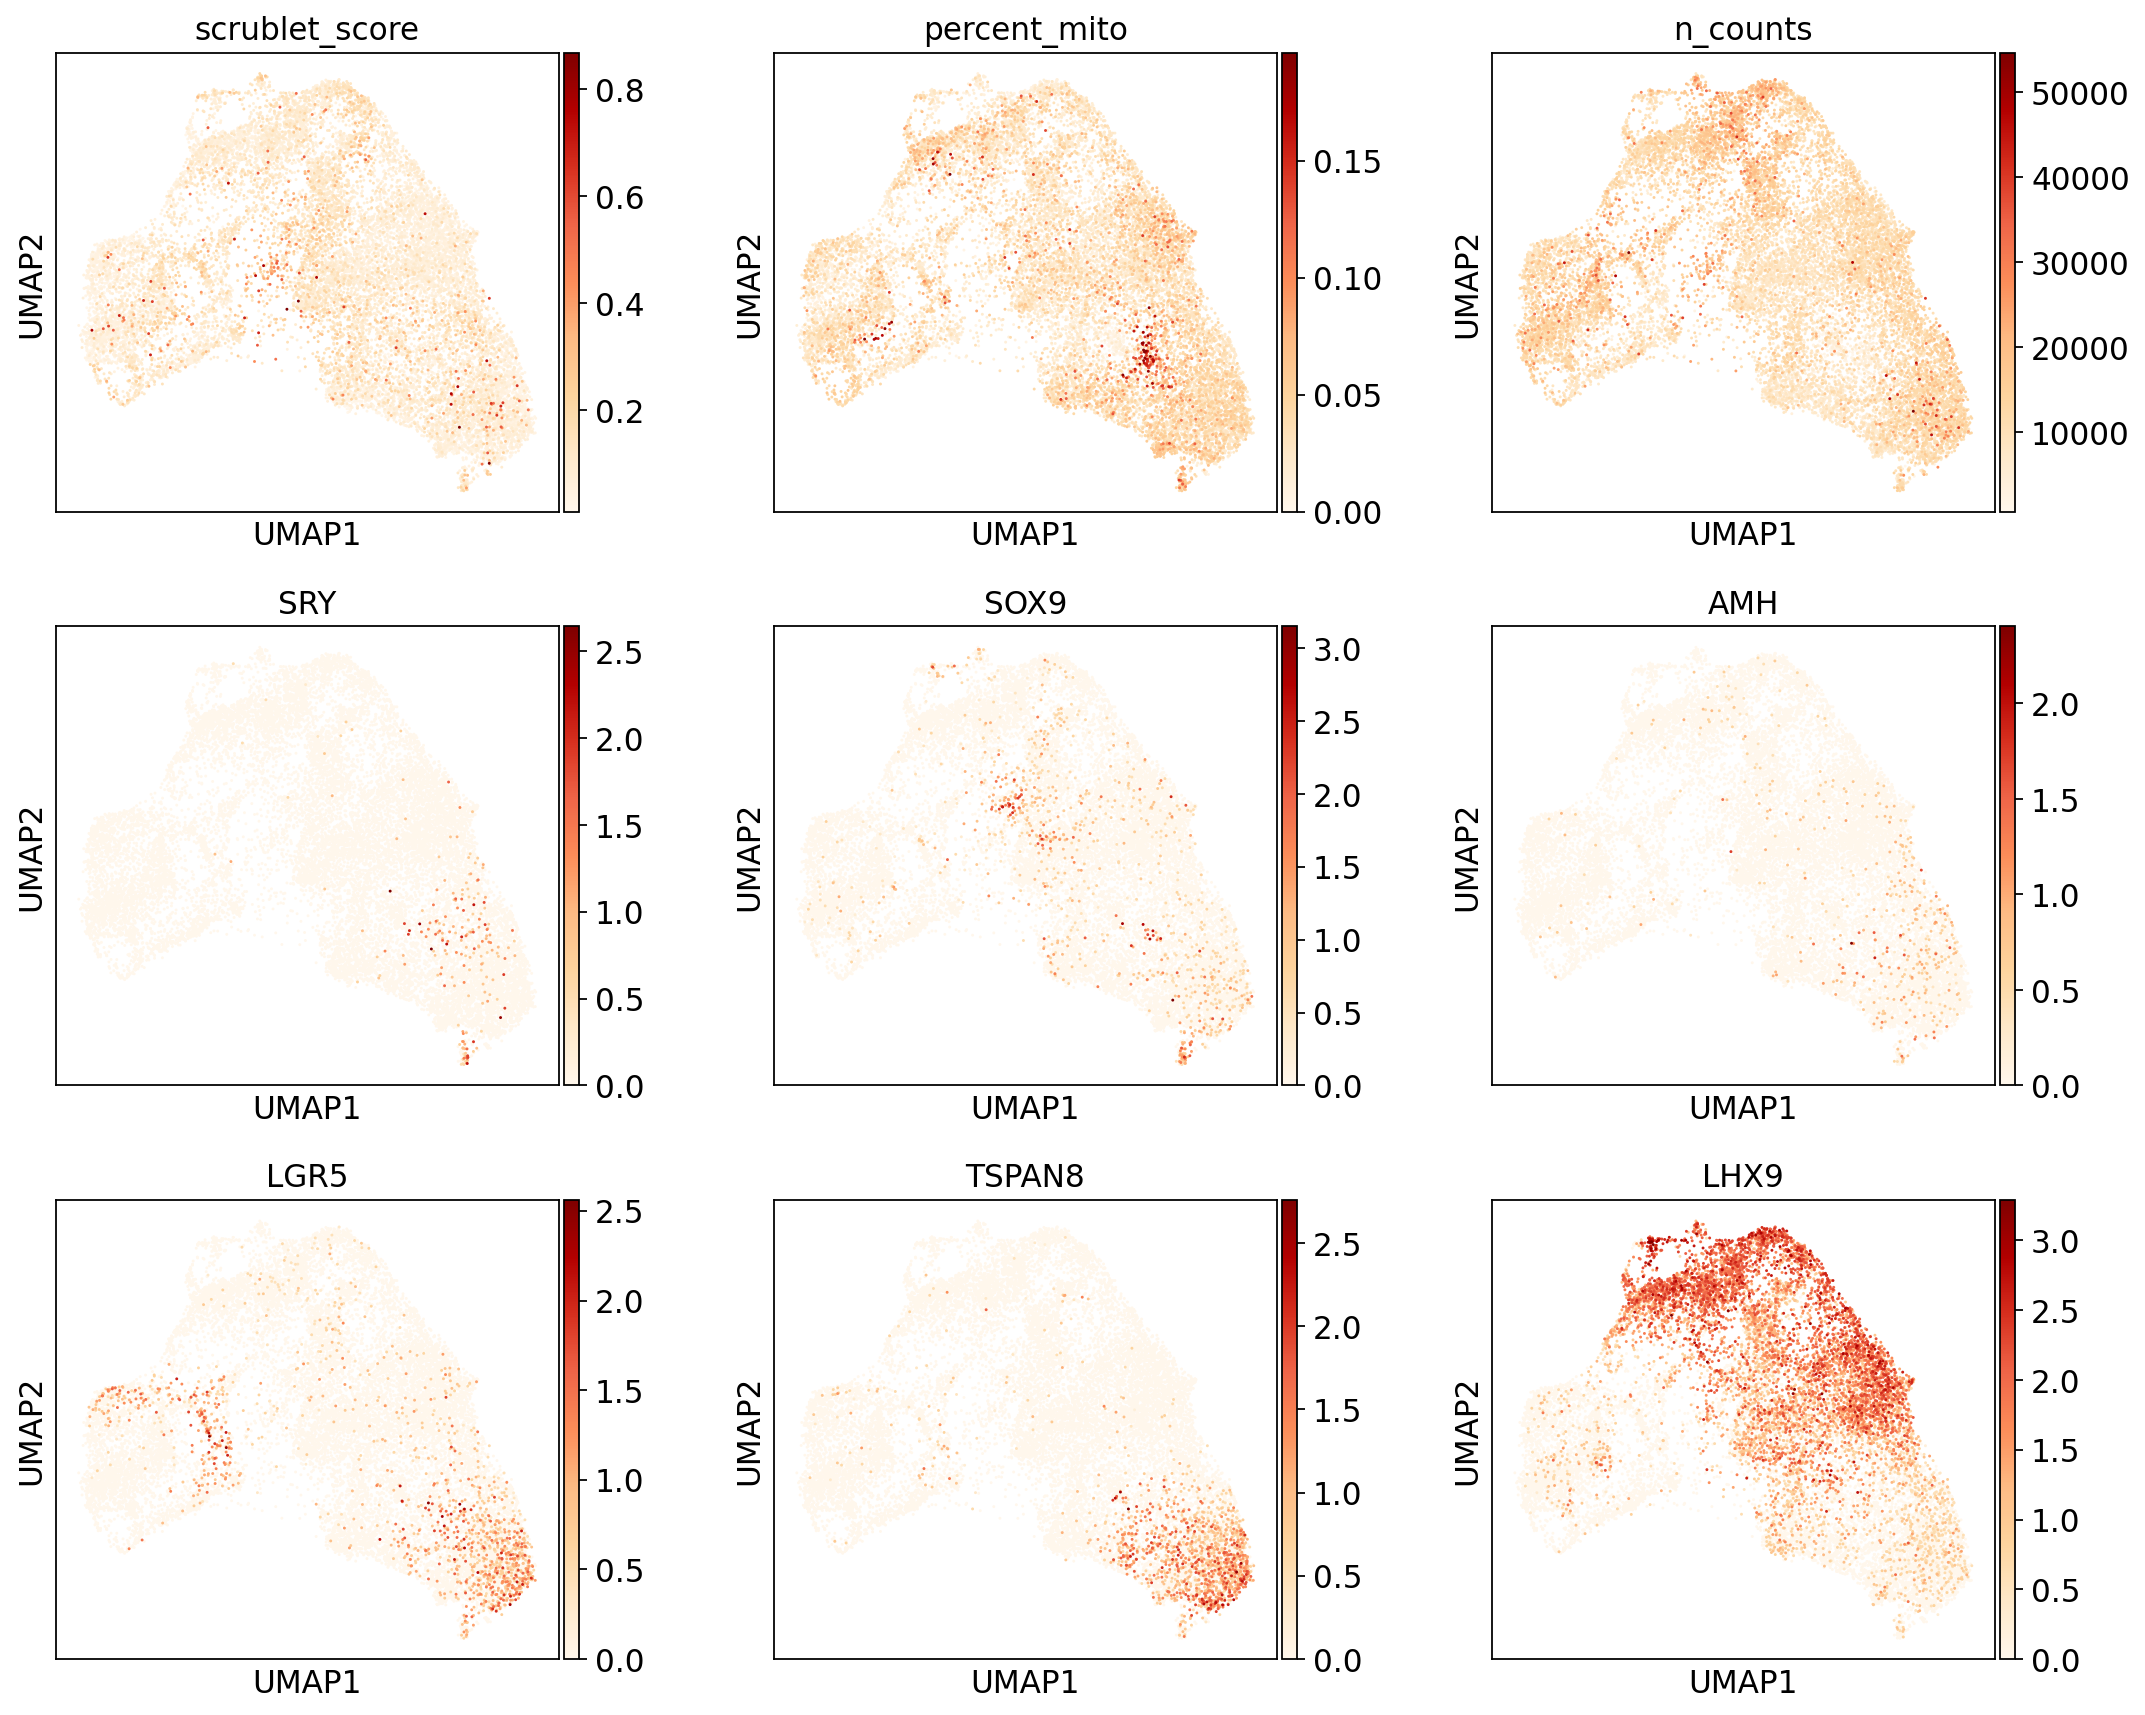

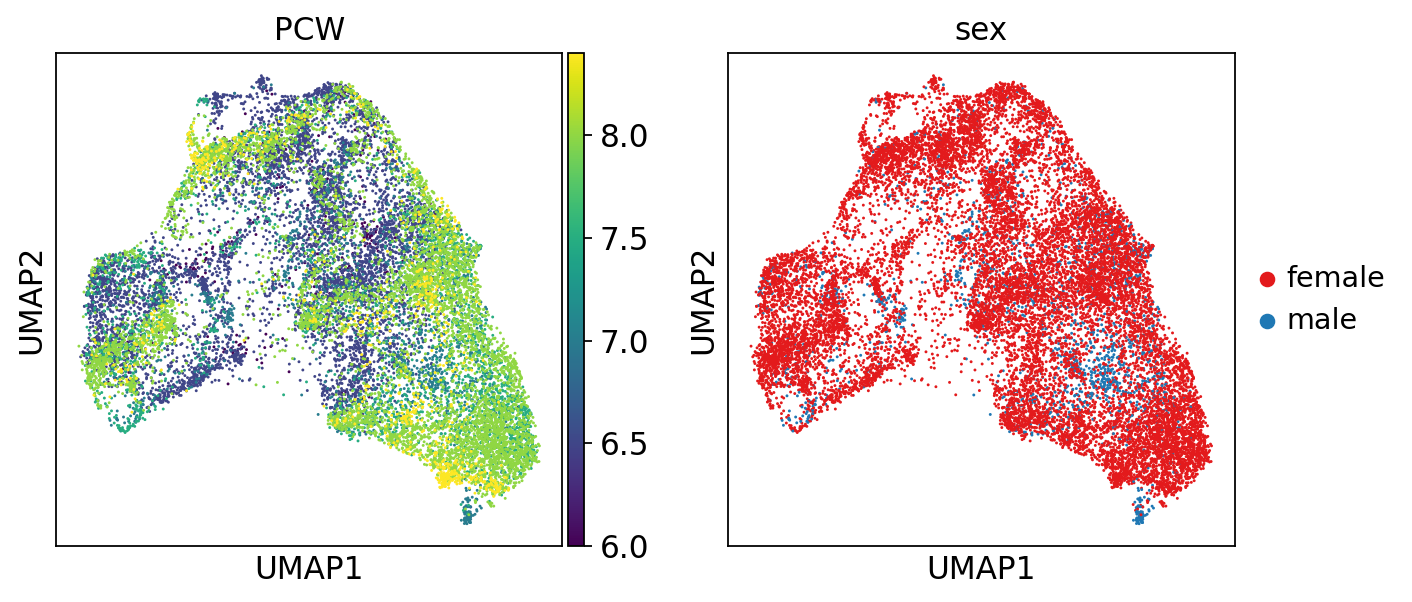

In [74]:
sc.pl.umap(
    adata,
    color=['scrublet_score',  'percent_mito', 'n_counts', 'SRY', 'SOX9', 'AMH', 'LGR5', 'TSPAN8', 'LHX9'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)
sc.pl.umap(
    adata,
    color=['PCW', 'sex'])

In [71]:
marker_genes = {
    'mesothelial': {'LRRN4', 'UPK3B', 'KLK11'},
    'Gonadal':{'LHX9', 'GATA4', 'ARX'},
    'Supporting':{"WNT6", 'NR5A1'},
    'sKITLG': {'IL17B', 'KITLG', 'VSNL1', 'CDH7' ,'CRB1', 'THSD7A'},
    'sLGR5':{'LGR5', 'TSPAN8', 'SRY', 'EPHA4', 'CXCR4','NANOG',  'RIMS4', 'CCKBR', 'HSD17B14'},
    'granulosa':{'OSR1', 'FOXL2', "IRX3", "RDH10", 'NOTCH3'},
    'OSE':{'LHX2'},
    'Sertoli': {'SOX9', 'INHBB', 'DHH', 'AMH'},
    'sPAX8': {'PAX8'},
    'Stromal':{'DCN', 'PDGFRA', 'TCF21'},
    'Stromal_extra':{'NR2F1', 'GATA2', 'RSPO3'},
#     'Stromal_gond':{'GATA4', 'ARX'},
    'Leydig':{'INSL3', 'HHIP', 'PTCH2', 'FDX1'},
    'PGCs': {'POU5F1', 'NANOS3'},
#     'Germ Cells': {'DAZL'},
    'epithelial': {"EPCAM", "KRT19"},
    'neural': {'ASCL1'},
    'endothelial': {'PECAM1', 'CDH5'},
#     'immune': {'PTPRC'},
    'erythroid': {"GYPC", "HBA1"},
    'perivascular': {"PDGFRB", 'ACTA2'},
    'erythroid': {"GYPC", "HBA1"}
}
# sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale = 'var')

In [72]:
# adata.obs['celltype'] = adata.obs['leiden'].tolist()
# adata.obs.at[adata.obs['leiden'] == '0', 'celltype'] = 'CoelEpi_LHX9_cycling'
# adata.obs.at[adata.obs['leiden'] == '1', 'celltype'] = 'sKITLG'
# adata.obs.at[adata.obs['leiden'] == '2', 'celltype'] = 'sLGR5'
# adata.obs.at[adata.obs['leiden'] == '3', 'celltype'] = 'preGC_I'
# adata.obs.at[adata.obs['leiden'] == '4', 'celltype'] = 'Sertoli'
# adata.obs.at[adata.obs['leiden'] == '5', 'celltype'] = 'Doublet'
# adata.obs.at[adata.obs['leiden'] == '6', 'celltype'] = 'Gi'
# adata.obs.at[adata.obs['leiden'] == '7', 'celltype'] = 'sPAX8e'
# adata.obs.at[adata.obs['leiden'] == '8', 'celltype'] = 'lowQC'
# adata.obs.at[adata.obs['leiden'] == '9', 'celltype'] = 'Doublet'
# adata.obs.at[adata.obs['leiden'] == '10', 'celltype'] = 'CoelEpi_GATA2'
# adata.obs.at[adata.obs['leiden'] == '11', 'celltype'] = 'CoelEpi_LHX9'
# adata.obs.at[adata.obs['leiden'] == '12', 'celltype'] = 'CoelEpi_LHX9'
# set(adata.obs['celltype'])
# sc.pl.umap(adata, color=['celltype'])
# adata.obs['celltype'].cat.reorder_categories(['CoelEpi_GATA2', 'CoelEpi_LHX9', 'CoelEpi_LHX9_cycling',  'Gi', 
#                                              'sKITLG', 'sLGR5', 'sPAX8e', 
#                                               'preGC_I',  'Sertoli',  'lowQC', 'Doublet'], inplace=True)

# sc.pl.umap(adata, color=['celltype'])
# sc.pl.umap(adata, color=['celltype_v2', 'celltype'], ncols = 2, legend_loc='on data', legend_fontsize=8)

In [73]:
# adata.obs['sex_celltype'] = adata.obs.apply(lambda x: '_'.join(x[[ 'celltype', 'sex']]),axis=1)
# sc.pl.dotplot(adata[[ i in ['Sertoli', 'sLGR5'] for i in adata.obs['celltype']]], ['SOX9', 'SRY', 'AMH'], groupby='sex_celltype', standard_scale = 'var')